In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm

import matplotlib.animation as animation
from IPython.display import Video

## 1. Select the Ginea-Pig (Ensemble $M_{23}$)

I selected ensemble member #23 ($M_{23}$) [arbitrarily...](https://media.gettyimages.com/id/961004764/nl/foto/east-rutherford-nj-michael-jordan-of-the-chicago-bulls-shoots-a-free-throw-against-the-new.jpg?s=2048x2048&w=gi&k=20&c=fZTcydkAJj5nTqfD4O-0kbGugXnFTPDfKYN0GPnNHTo=)

In [2]:
pset_23 = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_023.zarr')

In [3]:
# Extract the coordinates of the particles at diffferent depths
level_indexes = {}
dz = 100
n_levels = 16

for i in range(n_levels):
    level_indexes[i*dz] = pset_23.trajectory[i::n_levels]

In [4]:
p23 = pset_23.isel(trajectory=level_indexes[100])

## 2. Function to get indexes of neighbour particles

In [5]:
def neighbour_particles(pset, lon, lat, delta_deg):
    """
    Function to find the particles in a certain radius around a point
    pset: xarray dataset with the particle data
    lon: longitude of the point
    lat: latitude of the point
    delta_deg: radius around the point in degrees
    
    Returns: the indexes of the particles in the radius around the point
    """
    
    lon_conditional = np.logical_and(pset.lon[:,0]>=lon-delta_deg, pset.lon[:,0]<=lon + delta_deg)
    lat_conditional = np.logical_and(pset.lat[:,0]>=lat-delta_deg, pset.lat[:,0]<=lat + delta_deg)
    s = np.where(np.logical_and(lon_conditional, lat_conditional))[0]
    return s

## 3. Build Dataset $\forall$ members

In [6]:
skip_member = 23

member = 1
path = f'/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_{member:03d}.zarr'
pset_members = xr.open_zarr(path)
pset_members = pset_members.isel(trajectory=level_indexes[100])

centered_lon = -73
centered_lat = 36
delta_deg = 1/32

particle_index = neighbour_particles(pset_members, centered_lon, centered_lat, delta_deg)
pset_members = pset_members.isel(trajectory=particle_index)

for member in tqdm(range(2,51)):
    if member == skip_member:
        continue
    else:
        path = f'/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_{member:03d}.zarr'
        pset_members_aux = xr.open_zarr(path)
        pset_members_aux = pset_members_aux.isel(trajectory=level_indexes[100])
        pset_members_aux = pset_members_aux.isel(trajectory=particle_index)
        
        pset_members = xr.concat([pset_members, pset_members_aux], dim='trajectory')
    

100%|██████████| 49/49 [00:53<00:00,  1.09s/it]


In [7]:
pset_members

<xarray.Dataset> Size: 5MB
Dimensions:     (trajectory: 441, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 4kB 32241 32257 32273 ... 34289 34305 34321
Data variables:
    lat         (trajectory, obs) float64 1MB dask.array<chunksize=(9, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 1MB dask.array<chunksize=(9, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 1MB dask.array<chunksize=(9, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 1MB dask.array<chunksize=(9, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

## 4. Build PDFs $\forall$ members

In [8]:
def compute_probabilities(pset, ntime, nx, ny, domain_limits):
    P = np.zeros((ntime, nx, ny))

    for time in tqdm(range(0, ntime)):
        p_aux, x_, y_ = np.histogram2d(pset.lon[:, time].T, pset.lat[:, time].T, bins=[nx, ny], range=domain_limits, density=True)
        P[time] = p_aux/p_aux.sum()

        P[np.where(P == 0)] = np.nan
        
    return P, x_, y_

In [9]:
nx, ny = 54, 41
domain_limits = [[-80, -40], [15, 45]]

P_members, x_, y_ = compute_probabilities(pset_members, 364, nx, ny, domain_limits)

  0%|          | 0/364 [00:00<?, ?it/s]

100%|██████████| 364/364 [04:28<00:00,  1.35it/s]


## 5. Build PDF for $M_{23}$

In [10]:
centered_lon = -73
centered_lat = 36
delta_deg = 1/3

indexes = neighbour_particles(p23, centered_lon, centered_lat, delta_deg)
p23_set1 = p23.isel(trajectory=indexes)

example = neighbour_particles(p23, centered_lon, centered_lat, 1/32)
pmembers_example = p23.isel(trajectory=example)

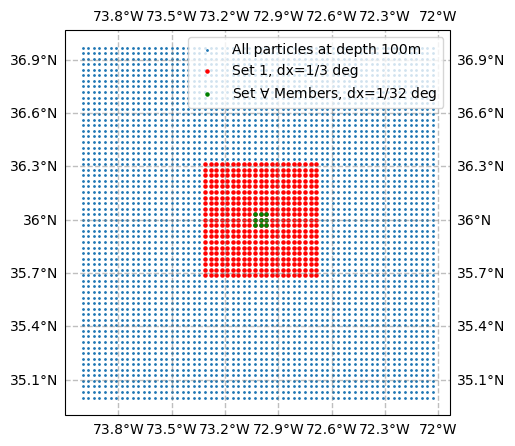

In [11]:
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

plt.scatter(p23.lon[:,0], p23.lat[:,0], s=1, label='All particles at depth 100m')
plt.scatter(p23_set1.lon[:,0], p23_set1.lat[:,0], s=5, c='r', label='Set 1, dx=1/3 deg')
plt.scatter(pmembers_example.lon[:,0], pmembers_example.lat[:,0], s=5, c='g', label=r'Set $\forall$ Members, dx=1/32 deg')

plt.legend()

In [12]:
nx, ny = 54, 41
domain_limits = [[-80, -40], [15, 45]]

P_23_s1, x_, y_ = compute_probabilities(p23_set1, 364, nx, ny, domain_limits)

100%|██████████| 364/364 [00:25<00:00, 14.04it/s]


## 6. Plot the PDFs

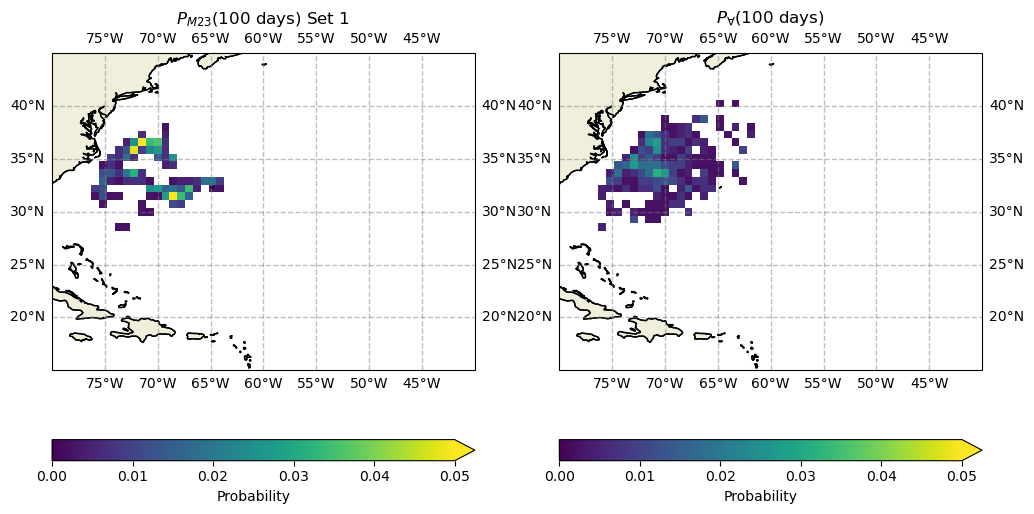

In [13]:
#plot P and P_kde in two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': cartopy.crs.PlateCarree()})
axs[0].coastlines()
axs[1].coastlines()

# add Land and Ocean Features
axs[0].add_feature(cartopy.feature.LAND, edgecolor='black')
axs[1].add_feature(cartopy.feature.LAND, edgecolor='black')

gl = axs[0].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl = axs[1].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

tau = 100

axs[0].set_title(r'$P_{M23}($' + f'{tau} days) Set 1')
axs[1].set_title(r'$P_{\forall}($' + f'{tau} days)')

im = axs[0].pcolormesh(x_, y_, P_23_s1[tau].T, vmin=0, vmax=0.05)
fig.colorbar(im, ax=axs[0], orientation='horizontal', label='Probability', extend='max')
im = axs[1].pcolormesh(x_, y_, P_members[tau].T, vmin=0, vmax=0.05)
fig.colorbar(im, ax=axs[1], orientation='horizontal', label='Probability', extend='max')


## 7. Animate the PDFs

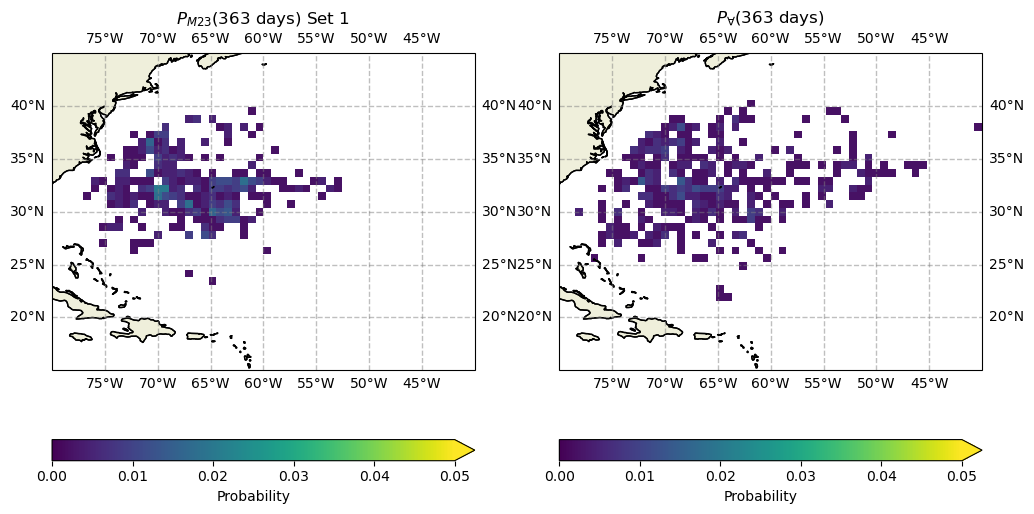

In [14]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': cartopy.crs.PlateCarree()})
# axs[0].coastlines()
# axs[1].coastlines()

# # add Land and Ocean Features
# axs[0].add_feature(cartopy.feature.LAND, edgecolor='black')
# axs[1].add_feature(cartopy.feature.LAND, edgecolor='black')

# gl = axs[0].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# gl = axs[1].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# tau = 0
# axs[0].set_title(r'$P_{M23}($' + f'{tau} days) Set 1')
# axs[1].set_title(r'$P_{\forall}($' + f'{tau} days)')

# im1 = axs[0].pcolormesh(x_, y_, P_23_s1[tau].T, vmin=0, vmax=0.05)
# im2 = axs[1].pcolormesh(x_, y_, P_members[tau].T, vmin=0, vmax=0.05)

# fig.colorbar(im1, ax=axs[0], orientation='horizontal', label='Probability', extend='max')
# fig.colorbar(im2, ax=axs[1], orientation='horizontal', label='Probability', extend='max')

# def animate(tau):
#     im1.set_array(P_23_s1[tau].T.ravel())
#     im2.set_array(P_members[tau].T.ravel())
#     # update the title
#     axs[0].set_title(r'$P_{M23}($' + f'{tau} days) Set 1')
#     axs[1].set_title(r'$P_{\forall}($' + f'{tau} days)')
#     return im1, im2

# ani = animation.FuncAnimation(fig, animate, frames=364, interval=100, blit=True)

# # save the animation
# ani.save('P_M23_s1_P_all.mp4', writer='ffmpeg', fps=10)


In [15]:
# Specify the path to your video file
video_path = 'P_M23_s1_P_all.mp4'

# Display the video
Video(video_path)

## 8. Build different set of particles for Member 23 simulations

In [16]:
np.random.seed(0)

centered_lon = -73
centered_lat = 36

nx, ny = 54, 41
domain_limits = [[-80, -40], [15, 45]]

p23_sets = {} # dictionary to store the different sets of particles
P_23_sets = {} # dictionary to store the probabilities of the different sets of particles

p23_sets['set1'] = p23_set1
P_23_sets['set1'] = P_23_s1

for j, delta_deg in enumerate(np.arange(1/3 + 1/32, 1, 1/32)):
    indexes = neighbour_particles(p23, centered_lon, centered_lat, delta_deg)
    sampled_indexes = np.random.choice(indexes, 441, replace=False)
    
    p_aux = p23.isel(trajectory=sampled_indexes)
    p23_sets[f'set{j+2}'] = p_aux
    
    Prob_aux, x_, y_ = compute_probabilities(p_aux, 364, nx, ny, domain_limits)
    P_23_sets[f'set{j+2}'] = Prob_aux
    
    

100%|██████████| 364/364 [00:02<00:00, 137.73it/s]


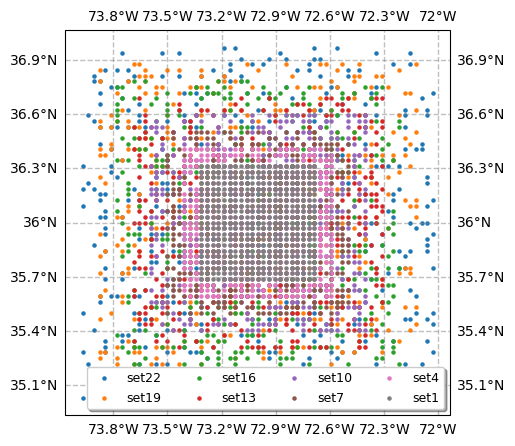

In [17]:
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

for i in range(22, 0, -3):
    key = f'set{i}'
    plt.scatter(p23_sets[key].lon[:,0], p23_sets[key].lat[:,0], s=5, label=key)

plt.legend(ncol=4, fontsize=9, shadow=True)

## 9. Compare the $P_{M23}$ subsets against $P_{\forall}$

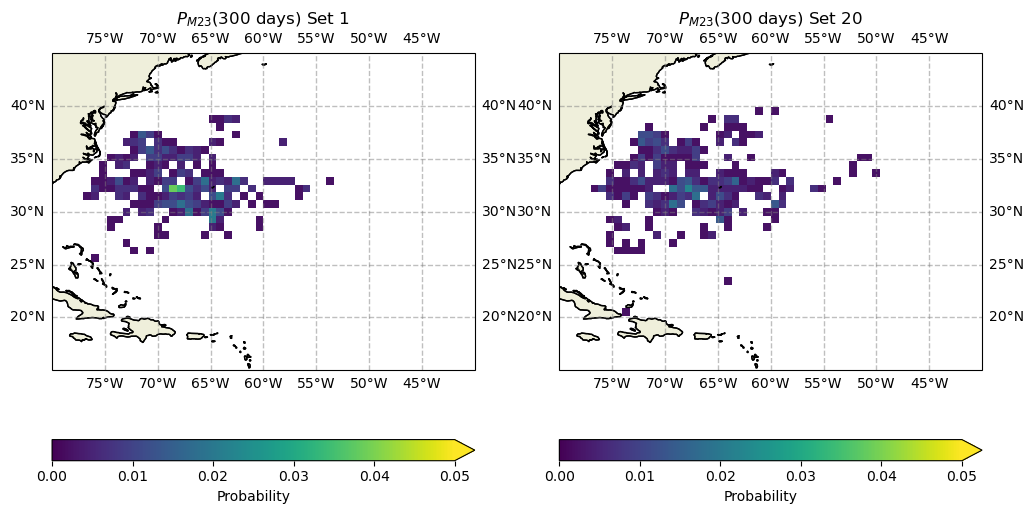

In [18]:
#plot P and P_kde in two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': cartopy.crs.PlateCarree()})
axs[0].coastlines()
axs[1].coastlines()

# add Land and Ocean Features
axs[0].add_feature(cartopy.feature.LAND, edgecolor='black')
axs[1].add_feature(cartopy.feature.LAND, edgecolor='black')

gl = axs[0].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl = axs[1].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

tau = 300

axs[0].set_title(r'$P_{M23}($' + f'{tau} days) Set 1')
axs[1].set_title(r'$P_{M23}($' + f'{tau} days) Set 20')


im = axs[0].pcolormesh(x_, y_, P_23_sets['set1'][tau].T, vmin=0, vmax=0.05)
fig.colorbar(im, ax=axs[0], orientation='horizontal', label='Probability', extend='max')
im = axs[1].pcolormesh(x_, y_, P_23_sets['set20'][tau].T, vmin=0, vmax=0.05)
fig.colorbar(im, ax=axs[1], orientation='horizontal', label='Probability', extend='max')

## 10. Entropy of the distributions

In [19]:
# entropy
def entropy(Pdf):
    Pdf = Pdf/np.nansum(Pdf)
    return -np.nansum(Pdf*np.log(Pdf))

def kullback_leibler(P, Q):
    P = P/np.nansum(P)
    Q = Q/np.nansum(Q)
    return np.nansum(P*np.log(P/Q))

In [20]:
H_members = np.zeros(364)
H_23_sets = {}

D_P23ooPmembers = {}
D_mm = np.zeros(364)

for i in range(364):
    H_members[i] = entropy(P_members[i])
    for key in P_23_sets.keys():
        if key not in H_23_sets.keys():
            H_23_sets[key] = np.zeros(364)
            D_P23ooPmembers[key] = np.zeros(364)
            
        H_23_sets[key][i] = entropy(P_23_sets[key][i])
        D_P23ooPmembers[key][i] = kullback_leibler(P_members[i], P_23_sets[key][i])


Text(0, 0.5, 'Entropy (nats)')

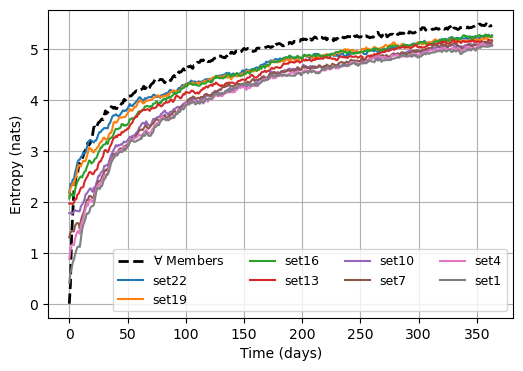

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(H_members, label=r'$\forall$ Members', c='k', lw=2, linestyle='--')


for i in range(22, 0, -3):
    key = f'set{i}'
    ax.plot(H_23_sets[key], label=key)
    
plt.legend(ncol=4, fontsize=9)
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('Entropy (nats)')


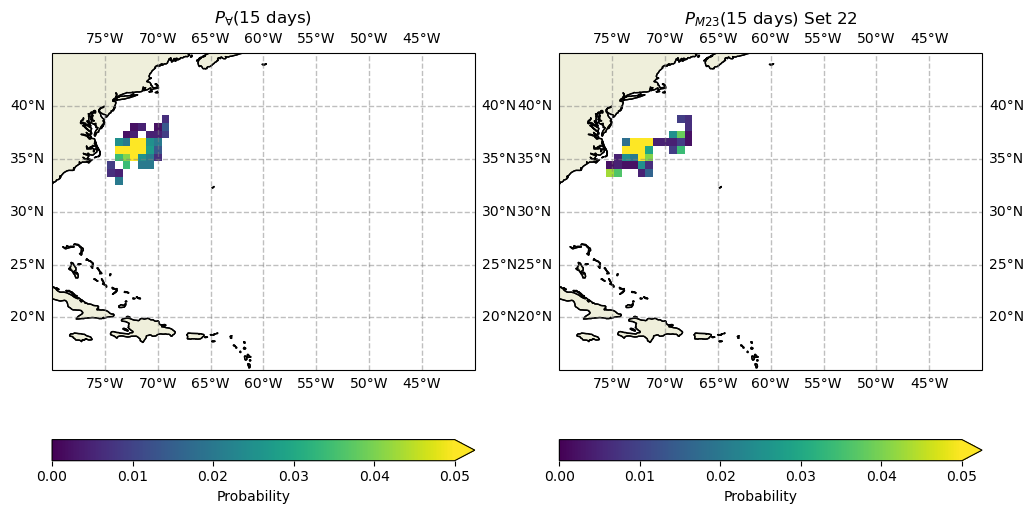

In [23]:
#plot P and P_kde in two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': cartopy.crs.PlateCarree()})
axs[0].coastlines()
axs[1].coastlines()

# add Land and Ocean Features
axs[0].add_feature(cartopy.feature.LAND, edgecolor='black')
axs[1].add_feature(cartopy.feature.LAND, edgecolor='black')

gl = axs[0].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl = axs[1].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

tau = 15

axs[0].set_title(r'$P_{\forall}($' + f'{tau} days)')
axs[1].set_title(r'$P_{M23}($' + f'{tau} days) Set 22')


im = axs[0].pcolormesh(x_, y_, P_members[tau].T, vmin=0, vmax=0.05)
fig.colorbar(im, ax=axs[0], orientation='horizontal', label='Probability', extend='max')
im = axs[1].pcolormesh(x_, y_, P_23_sets['set22'][tau].T, vmin=0, vmax=0.05)
fig.colorbar(im, ax=axs[1], orientation='horizontal', label='Probability', extend='max')

## 11. Kullback-Leibler distance (Relative Entropy)

$D_{KL}(P||Q) = \sum_{x \in X} P(x) \log\big( \frac{P(x)}{Q(x)}\big)$

Consider two probability distributions P and Q. Usually, P represents the data, the observations, or a measured probability distribution. Distribution Q represents instead a theory, a model, a description or an approximation of P. The Kullback–Leibler divergence D KL ( P ∥ Q ) {\displaystyle D_{\text{KL}}(P\parallel Q)} is then interpreted as the average difference of the number of bits required for encoding samples of P using a code optimized for Q rather than one optimized for P.


Text(0.5, 1.0, 'Kullback-Leibler divergence between $P_{\\forall}$ and $P_{M23}$ subsets')

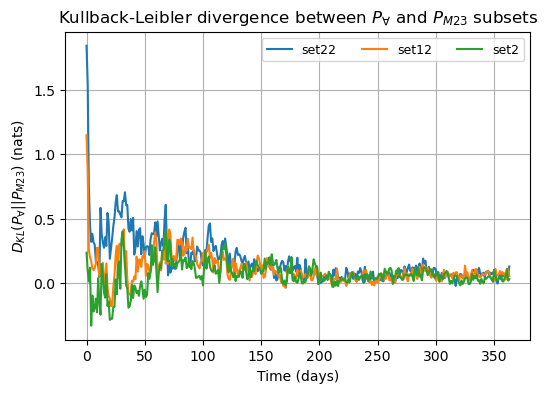

In [24]:
#plot the Kullback-Leibler divergence between P_23 and P_members
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i in range(22, 0, -10):
    key = f'set{i}'
    ax.plot(D_P23ooPmembers[key], label=key)
    
plt.legend(ncol=4, fontsize=9)
plt.grid()
ax.set_xlabel('Time (days)')
ax.set_ylabel(r'$D_{KL}(P_{\forall}||P_{M23})$ (nats)')
ax.set_title(r'Kullback-Leibler divergence between $P_{\forall}$ and $P_{M23}$ subsets')

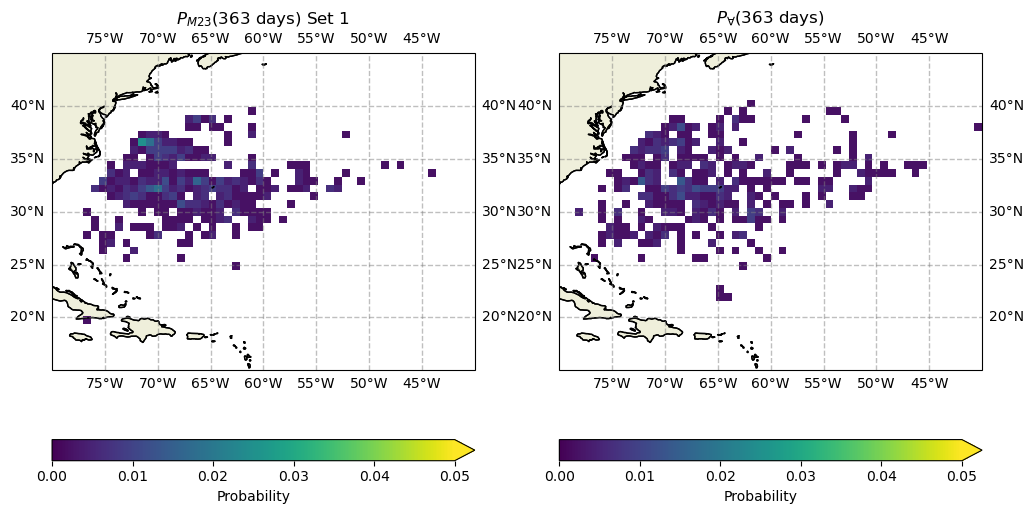

In [25]:
## 4. Animate the P dsitributions

# fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': cartopy.crs.PlateCarree()})
# axs[0].coastlines()
# axs[1].coastlines()

# # add Land and Ocean Features
# axs[0].add_feature(cartopy.feature.LAND, edgecolor='black')
# axs[1].add_feature(cartopy.feature.LAND, edgecolor='black')

# gl = axs[0].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# gl = axs[1].gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# tau = 0
# axs[0].set_title(r'$P_{M23}($' + f'{tau} days) Set 22')
# axs[1].set_title(r'$P_{\forall}($' + f'{tau} days)')

# im1 = axs[0].pcolormesh(x_, y_, P_23_sets['set22'][tau].T, vmin=0, vmax=0.05)
# im2 = axs[1].pcolormesh(x_, y_, P_members[tau].T, vmin=0, vmax=0.05)

# fig.colorbar(im1, ax=axs[0], orientation='horizontal', label='Probability', extend='max')
# fig.colorbar(im2, ax=axs[1], orientation='horizontal', label='Probability', extend='max')

# def animate(tau):
#     im1.set_array(P_23_sets['set22'][tau].T.ravel())
#     im2.set_array(P_members[tau].T.ravel())
#     # update the title
#     axs[0].set_title(r'$P_{M23}($' + f'{tau} days) Set 1')
#     axs[1].set_title(r'$P_{\forall}($' + f'{tau} days)')
#     return im1, im2

# ani = animation.FuncAnimation(fig, animate, frames=364, interval=100, blit=True)

# # plt.show()

# # save the animation
# ani.save('P_M23_s22_P_all.mp4', writer='ffmpeg', fps=10)


In [26]:
# Specify the path to your video file
video_path = 'P_M23_s22_P_all.mp4'

# Display the video
Video(video_path)

## 12. Cross Entropy

Text(0, 0.5, 'Mutual information (nats)')

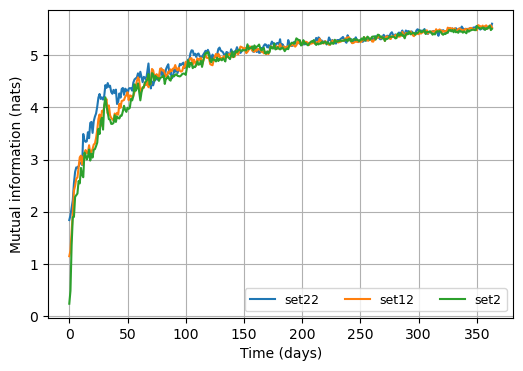

In [163]:
#plot the Kullback-Leibler divergence between P_23 and P_members
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i in range(22, 0, -10):
    key = f'set{i}'
    ax.plot(H_members + D_P23ooPmembers[key], label=key)
    
plt.legend(ncol=4, fontsize=9)
plt.grid()
ax.set_xlabel('Time (days)')
ax.set_ylabel('Mutual information (nats)')